# Modélisation du système bactérie/anticorps

Nadir Ait Kheddache, Idriss Alaoui Souliman, Fabien Benthami, Alma Draeger, Alexandre Janin

In [270]:
#Imports
import numpy as np
import ipywidgets as widgets
import matplotlib
import matplotlib.pyplot as plt
import IPython

In [271]:
#Variables globales
#probabilité d'avoir chaque type de cellule (0: vide, 1: bactérie, 2: globule blanc, 3: nutriments)
#la somme des probabilités doit être égale à 1
proba = [0.5, 0.1, 0.1, 0.3]

#probabilité qu'une cellule vide se transforme en nutriments
proba_apparition_nutriments = 0.1

#probabilité qu'un globule blanc apparaisse spontanément
proba_apparition_gb = 0

#probabilité qu'un globule blanc dispairaisse à chaque tour
proba_apoptose = 0.01

#nombre de globules blancs qui apparaissent à chaque tour
#nb_gb_apparition = 2

#nombre de GB nécessaires pour tuer une bactérie
nb_gb_necessaires = 2

#nombre de GB nécessaires pour qu'un GB apparaisse
nb_gb_reproduction = 4

#nombre de GB voisins à partir duquel le GB central meurt
nb_gb_surpop = 5

#nombres de bactéries voisines à partir duquel la bactérie meurt 
nb_b_surpop = 5

#nombres de bactéries voisines à partir duquel le globule blanc meurt 
nb_b_necessaires = 5

#Symbole qui représente chaque valeur de cellule
cara = ['-', 'B', 'G', 'n']

In [272]:
#Paramètres
infiniCheckbox = widgets.Checkbox(value = False, description = "Infini", disabled = False)
display(infiniCheckbox)

Checkbox(value=False, description='Infini')

In [273]:
def matrice(l, h):
    """ int^2 -> int[][]
    largeur > 0, hauteur > 0
    Renvoie une matrice de 0 de l colonnes et h lignes"""
    
    return [[aleatoire() for x in range(l)] for y in range(h)]

In [274]:
def aleatoire():
    """float -> int
    Renvoie le type de cellule (0, 1, 2, 3) selon le nombre aléatoire tiré"""
    
    alea = np.random.rand()
    
    for i in range(len(proba)):
        p = proba[i]
        if alea <= p:
            return i
        else:
            alea -= p
            
    return 0

In [275]:
def printmatrice(M):
    """int[][] -> NoneType
    Affiche la matrice M"""
    IPython.display.clear_output()
    for ligne in M:
        s = ""
        for cell in ligne:
            s += cara[cell] + ' '
        print(s + "\n")

In [276]:
def voisinage(M, x, y):
    """int[][] * int * int * bool-> int[]
    Renvoie la liste des voisins de la case (x, y).
    Si infini est False, on ne prend pas les voisins hors de la matrice"""
    v = [0, 0, 0, 0]
    
    ymax = len(M)
    xmax = len(M[0])
    
    infini = infiniCheckbox.value
    
    for i in [x - 1, x, x + 1]:
        if (0 <= i and i < xmax):
            for j in [y - 1, y, y + 1]:
                if (0 <= j and j < ymax):
                        if (i, j) != (x, y): #Si i, j n'est pas la case centrale
                            v[M[j][i]] += 1
    return v

In [277]:
def next_step_matrice(M):
    """int[][] -> int [][]
    Renvoie la matrice à l'étape suivante."""
    
    nv_M = list(M)
    
    for y in range(len(M)):
        for x in range(len(M[y])):
            nv_M[y][x] = next_step_cellule(M[y][x], voisinage(M, x, y))
            
    return nv_M

In [278]:
def next_step_cellule(c, voisins):
    """int * int[] -> int
    Hypothèse: c = 0 ou 1 ou 2 ou 3
    Renvoie l'état suivant d'une cellule c en fonction de son état actuel et de ses voisins."""
    
    vides = voisins[0]
    bacteries = voisins[1]
    globules = voisins[2]
    nutriments = voisins[3]
    
    
    if (c == 0): #La cellule est vide
        if (globules >= nb_gb_reproduction): #Un nouveau GB est créé
            return 2
        elif (np.random.rand() <= proba_apparition_gb):
            return 2
        elif (np.random.rand() <= proba_apparition_nutriments): #Un nutriment apparait
            return 3
        else: #La cellule reste vide
            return 0
        
    if (c == 1): #Bactérie
        if (globules >= nb_gb_necessaires): #Les GB tuent la bactérie
            return 0
        elif(bacteries >= nb_b_surpop): #La bactérie meurt (surpopulation)
            return 0
        else: #La bactérie survit
            return 1
        
    if (c == 2): #Globule blanc
        if (bacteries >= nb_b_necessaires): #Il y a trop de bactéries, le GB meurt
            return 0
        elif (globules >= nb_gb_surpop): #Surpopulation
            return 0
        elif (np.random.rand() <= proba_apoptose): #Le GB meurt par apoptose
            return 0
        else: #Le GB survit
            return 2
        
    if (c == 3): #Nutriment
        if (bacteries > 0): #La bactérie voisine se multiplie
            return 1
        else: #La cellule reste un nutriment
            return 3
        
    print("Erreur: c invalide:", c)

In [279]:
mat = matrice(16,8)

In [280]:
def display_next_step(b):
    global mat
    global button
    global reset_button
    
    mat = next_step_matrice(mat)
    printmatrice(mat)
    
    display(reset_button)
    display(button)

In [281]:
def reset(b):
    global mat
    mat = matrice(16, 8)
    printmatrice(mat)
    display(reset_button)
    display(button)

In [282]:
reset_button = widgets.Button(
    description='Reset',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me!',
    icon='check'
)

button = widgets.Button(
    description='Next Step',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me!',
    icon='check'
)

button.on_click(display_next_step)
reset_button.on_click(reset)

display(reset_button)
display(button)

Button(button_style='info', description='Reset', icon='check', style=ButtonStyle(), tooltip='Click me!')

Button(button_style='info', description='Next Step', icon='check', style=ButtonStyle(), tooltip='Click me!')

In [283]:
def simulate(l, h, steps):
    """int -> int[][]
    Simule steps étapes et renvoie le résultat final"""
    mat = matrice(l, h)
    for i in range(steps):
        mat = next_step_matrice(mat)
        
    return mat

In [299]:
def compteur(mat):
    """int[][] -> (int, int)
    Renvoie le nombre de GB et bactéries dans une matrice"""
    compt_G=0
    compt_B=0
    for i in mat:
        for j in i:
            if j==2:
                compt_G=compt_G +1
            elif  j==1:
                compt_B=compt_B +1
    return (compt_G,compt_B)

In [285]:
def simulate_compte(steps, verbose=False):
    """int * bool -> (int, int)
    Renvoie le nombre de GB et bactéries apres steps étapes."""
    
    mat = matrice(10,10)
    
    resultsG = []
    resultsB = []
    
    for i in range(steps):
        nombre_G,nombre_B = compteur(mat)
        if verbose:
            print(i, nombre_G)
            print(i, nombre_B)
        resultsG.append(nombre_G)
        resultsB.append(nombre_B)
        mat = next_step_matrice(mat)
    
    return resultsG, resultsB

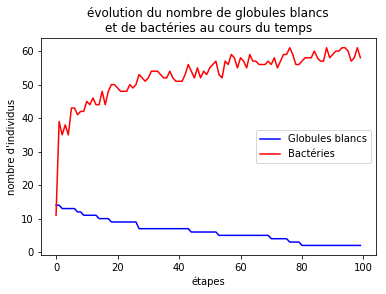

In [298]:
resultsG, resultsB = simulate_compte(100)

x = list(range(len(resultsG)))

plt.plot(x, resultsG, c = 'blue', label = "Globules blancs")
plt.plot(x, resultsB, c = 'red', label = "Bactéries")

plt.ylabel("nombre d'individus")
plt.xlabel("étapes")

plt.legend(loc = "best")

plt.title("évolution du nombre de globules blancs\net de bactéries au cours du temps")

plt.show()